In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

ModuleNotFoundError: No module named 'numpy'

In [ ]:
!pip install googletrans==4.0.0-rc1

^C


# Steps:
1) preprocessing
2) splitting
3) tokenize & padding
4) Create model & train
5) evaluate

# Preprocessing (cleaning the datasets):

1) remove html entity
2) change user tags (@xxx -> user)
3) remove urls
4) remove unnecessary symbol ('', !, ", ') -> cause a lot of noise in the dataset
5) remove stopwords

# 1| Import libraries

In [ ]:
import pandas as pd # read the csv
import re # regex to detect username, url, html entity 
import nltk # to use word tokenize (split the sentence into words)
from nltk.corpus import stopwords # to remove the stopwords
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
import time
from multiprocessing import Pool, cpu_count
from tqdm import tqdm

from keras.utils import to_categorical
from keras import backend as K


In [ ]:
# --- YOUR PARALLEL DATA AUGMENTATION PROJECT ---

# Back-translation function using a placeholder
# In a real project, this would be a translation API call, which is time-consuming.
# For this code to run without an internet connection, we will just append text.
def back_translate(text):
    time.sleep(0.01) # Simulate the time-consuming translation process
    # translator = Translator()
    # translated = translator.translate(text, src='en', dest='de').text
    # back_translated = translator.translate(translated, src='de', dest='en').text
    return text + " [AUGMENTED]"

# Function to run the augmentation and measure performance
def run_augmentation(data, num_cores):
    start_time = time.time()
    
    if num_cores == 1:
        print("Starting sequential run...")
        augmented_posts = [back_translate(post) for post in tqdm(data)]
    else:
        print(f"Starting parallel run on {num_cores} cores...")
        with Pool(num_cores) as p:
            augmented_posts = list(tqdm(p.imap(back_translate, data), total=len(data)))
            
    end_time = time.time()
    return augmented_posts, end_time - start_time
    
# 1. Load the original data and select the minority class to augment
original_data = pd.read_csv("/kaggle/input/hate-speech-and-offensive-language-detection/train.csv")
minority_class_posts = original_data[original_data['class'] == 0]['tweet'].tolist()
print(f"Number of posts in the minority class to augment: {len(minority_class_posts)}")

# 2. Perform and time the sequential augmentation (1 core)
sequential_augmented_posts, sequential_time = run_augmentation(minority_class_posts, 1)

# 3. Perform and time the parallel augmentation (all available cores)
num_cores = cpu_count()
parallel_augmented_posts, parallel_time = run_augmentation(minority_class_posts, num_cores)

print("\n--- Performance Results ---")
print(f"Sequential run time: {sequential_time:.2f} seconds")
print(f"Parallel run time:   {parallel_time:.2f} seconds")
print(f"Speedup: {sequential_time / parallel_time:.2f}x")

# 4. Combine original data with the new augmented data
augmented_df = pd.DataFrame({
    'tweet': parallel_augmented_posts,
    'class': [0] * len(parallel_augmented_posts) # Assign label 0 to augmented data
})
combined_data = pd.concat([original_data, augmented_df], ignore_index=True)

# 5. Save the new, larger dataset
combined_data.to_csv("augmented_train.csv", index=False)
print("\nNew augmented dataset saved as 'augmented_train.csv'")

Number of posts in the minority class to augment: 1430
Starting sequential run...


100%|██████████| 1430/1430 [00:14<00:00, 97.01it/s]

Starting parallel run on 4 cores...



100%|██████████| 1430/1430 [00:03<00:00, 383.44it/s]



--- Performance Results ---
Sequential run time: 14.75 seconds
Parallel run time:   3.86 seconds
Speedup: 3.82x

New augmented dataset saved as 'augmented_train.csv'


# 2| read the data

In [ ]:
data = pd.read_csv("augmented_train.csv")

data.head()

,count,hate_speech_count,offensive_language_count,neither_count,class,tweet
0,3.0,0.0,0.0,3.0,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,3.0,0.0,3.0,0.0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,3.0,0.0,3.0,0.0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3.0,0.0,2.0,1.0,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,6.0,0.0,6.0,0.0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


In [ ]:
# dataset shape to know how many tweets in the datasets
print(f"num of tweets: {data.shape}")

# extract the text and labels
tweet = list(data['tweet'])
labels = list(data['class'])

num of tweets: (26213, 6)


# 3| functions to clean the data

In [ ]:
#notes : all of the function taking 1 text at a time
stop_words = set(stopwords.words('english'))
# add rt to remove retweet in dataset (noise)
stop_words.add("rt")

# remove html entity:
def remove_entity(raw_text):
    entity_regex = r"&[^\s;]+;"
    text = re.sub(entity_regex, "", raw_text)
    return text

# change the user tags
def change_user(raw_text):
    regex = r"@([^ ]+)"
    text = re.sub(regex, "user", raw_text)

    return text

# remove urls
def remove_url(raw_text):
    url_regex = r"(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:'\".,<>?«»“”‘’]))"
    text = re.sub(url_regex, '', raw_text)

    return text

# remove unnecessary symbols
def remove_noise_symbols(raw_text):
    text = raw_text.replace('"', '')
    text = text.replace("'", '')
    text = text.replace("!", '')
    text = text.replace("`", '')
    text = text.replace("..", '')

    return text

# remove stopwords
def remove_stopwords(raw_text):
    tokenize = nltk.word_tokenize(raw_text)
    text = [word for word in tokenize if not word.lower() in stop_words]
    text = " ".join(text)

    return text

## this function in to clean all the dataset by utilizing all the function above
def preprocess(datas):
    clean = []
    # change the @xxx into "user"
    clean = [change_user(text) for text in datas]
    # remove emojis (specifically unicode emojis)
    clean = [remove_entity(text) for text in clean]
    # remove urls
    clean = [remove_url(text) for text in clean]
    # remove trailing stuff
    clean = [remove_noise_symbols(text) for text in clean]
    # remove stopwords
    clean = [remove_stopwords(text) for text in clean]

    return clean

In [ ]:
# call the cleaning function
clean_tweet = preprocess(tweet)

# 4| Splitting the dataset into test and validation

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(clean_tweet, labels, test_size=0.2, random_state=42)

In [ ]:
## Tokenizing -> basically we use tokenisation for many things, its commonly used for feature extraction in preprocessing. btw idk how it works as feature extraction tho :(
# declare the tokenizer
tokenizer = Tokenizer()
# build the vocabulary based on train dataset
tokenizer.fit_on_texts(X_train)
# tokenize the train and test dataset
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

# vocabulary size (num of unique words) -> will be used in embedding layer
vocab_size = len(tokenizer.word_index) + 1

In [ ]:
## Padding -> to uniform the datas
max_length = max(len(seq) for seq in X_train)

# to test an outlier case (if one of the test dataset has longer length)
for x in X_test:
    if len(x) > max_length:
        print(f"an outlier detected: {x}")

X_train = pad_sequences(X_train, maxlen = max_length)
X_test = pad_sequences(X_test, maxlen = max_length)

In [ ]:
# create hot_labels (idk whty tapi ini penting, kalo ga bakal error)
y_test = to_categorical(y_test, num_classes=3)
y_train = to_categorical(y_train, num_classes=3)

In [ ]:
# another look on the number of tweet in test and training data

print(f"num test tweet: {y_test.shape[0]}")
print(f"num train tweet: {y_train.shape[0]}")

num test tweet: 5243
num train tweet: 20970


# 5| Building the model

In [ ]:
def recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1(y_true, y_pred):
    precisions = precision(y_true, y_pred)
    recalls = recall(y_true, y_pred)
    return 2*((precisions*recalls)/(precisions+recalls+K.epsilon()))

In [ ]:
# change dis if u want
output_dim = 200

# LSTM model architechture (CNN + LSTM)
model = Sequential([
    # embedding layer is like idk
    Embedding(vocab_size, output_dim, input_length=max_length),
    # lstm for xxx
    LSTM(64, dropout=0.3, recurrent_dropout=0.3),
    # dropout to prevent overfitting
    Dropout(0.5),
    # dense to connect the previous output with current layer
    Dense(128, activation="relu"),
    # dropout to prevent overfitting
    Dropout(0.5),
    # this is output layer, with 3 class (0, 1, 2)
    Dense(3, activation="softmax"),
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy',f1,precision, recall])

In [ ]:
# checking the model parameters
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 28, 200)           3750800   
                                                                 
 lstm (LSTM)                 (None, 64)                67840     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 3)                 387       
                                                                 
Total params: 3827347 (14.60 MB)
Trainable params: 38273

In [ ]:
# Train the model
model_history = model.fit(
    X_train,
    y_train,
    batch_size = 64,
    epochs=10,
    validation_data=(X_test, y_test)
)

Epoch 1/10
328/328 [==============================] - 30s 78ms/step - loss: 0.4663 - accuracy: 0.8280 - f1: 0.8041 - precision: 0.8508 - recall: 0.7712 - val_loss: 0.2820 - val_accuracy: 0.8978 - val_f1: 0.8961 - val_precision: 0.9046 - val_recall: 0.8878
Epoch 2/10
328/328 [==============================] - 26s 78ms/step - loss: 0.2127 - accuracy: 0.9302 - f1: 0.9301 - precision: 0.9367 - recall: 0.9238 - val_loss: 0.2900 - val_accuracy: 0.9020 - val_f1: 0.9022 - val_precision: 0.9059 - val_recall: 0.8987
Epoch 3/10
328/328 [==============================] - 27s 81ms/step - loss: 0.1341 - accuracy: 0.9541 - f1: 0.9544 - precision: 0.9567 - recall: 0.9521 - val_loss: 0.3353 - val_accuracy: 0.8957 - val_f1: 0.8959 - val_precision: 0.8994 - val_recall: 0.8924
Epoch 4/10
328/328 [==============================] - 25s 76ms/step - loss: 0.0925 - accuracy: 0.9691 - f1: 0.9690 - precision: 0.9699 - recall: 0.9681 - val_loss: 0.4544 - val_accuracy: 0.8936 - val_f1: 0.8942 - val_precision: 0.89

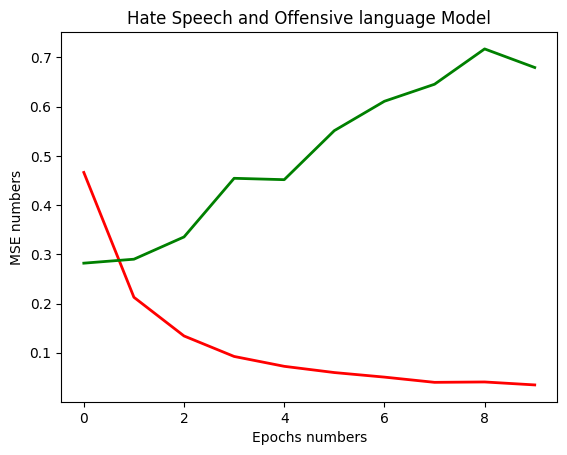

In [ ]:
import matplotlib.pyplot as plt
hist = model.history.history
plt.plot(hist['loss'],'r',linewidth=2, label='Training loss')
plt.plot(hist['val_loss'], 'g',linewidth=2, label='Validation loss')
plt.title('Hate Speech and Offensive language Model')
plt.xlabel('Epochs numbers')
plt.ylabel('MSE numbers')
plt.show()

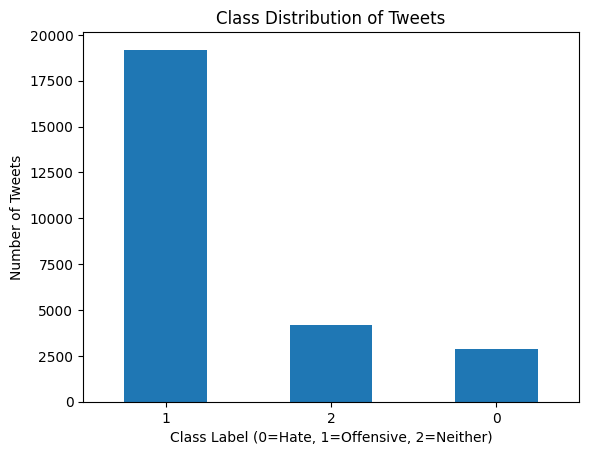

In [ ]:
import matplotlib.pyplot as plt

# Assuming 'data' is your DataFrame after loading augmented_train.csv
data['class'].value_counts().plot(kind='bar')
plt.title('Class Distribution of Tweets')
plt.xlabel('Class Label (0=Hate, 1=Offensive, 2=Neither)')
plt.ylabel('Number of Tweets')
plt.xticks(rotation=0)
plt.show()

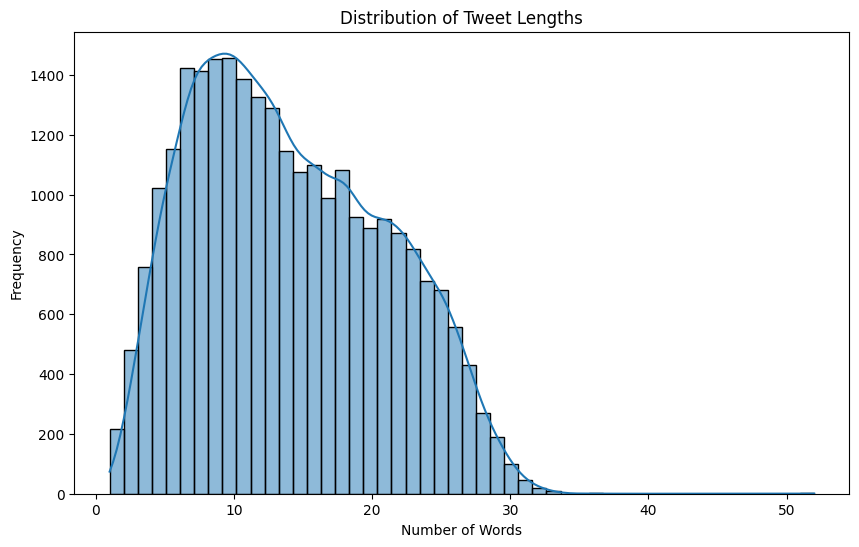

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a new column for tweet length
data['tweet_length'] = data['tweet'].apply(lambda x: len(str(x).split()))

plt.figure(figsize=(10, 6))
sns.histplot(data['tweet_length'], bins=50, kde=True)
plt.title('Distribution of Tweet Lengths')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.show()

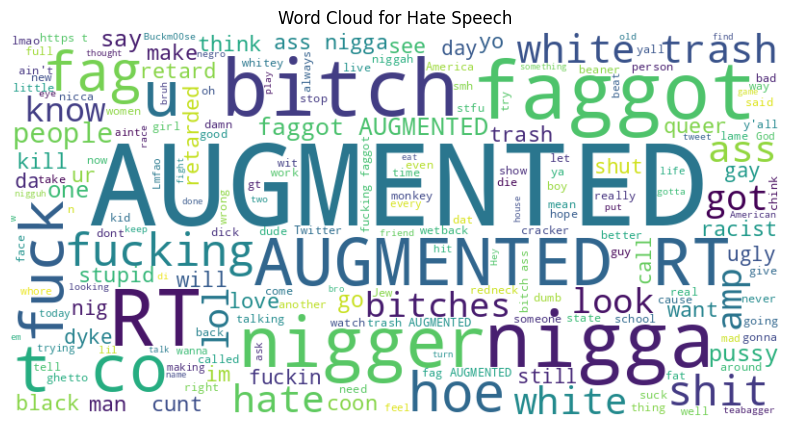

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Combine all tweets from a specific class (e.g., class 0 for hate speech)
hate_speech_text = " ".join(data[data['class'] == 0]['tweet'].tolist())

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(hate_speech_text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Hate Speech')
plt.show()

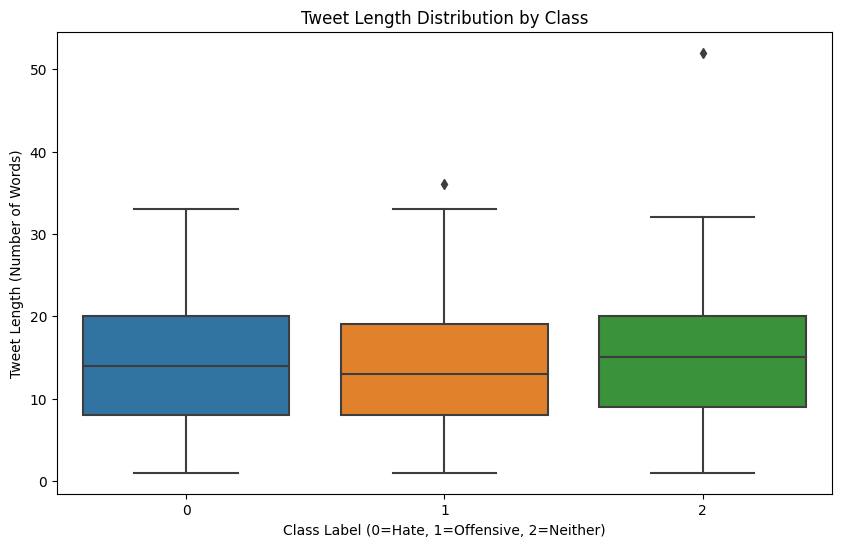

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'data' is your DataFrame after loading, with a 'tweet_length' column
plt.figure(figsize=(10, 6))
sns.boxplot(x='class', y='tweet_length', data=data)
plt.title('Tweet Length Distribution by Class')
plt.xlabel('Class Label (0=Hate, 1=Offensive, 2=Neither)')
plt.ylabel('Tweet Length (Number of Words)')
plt.show()

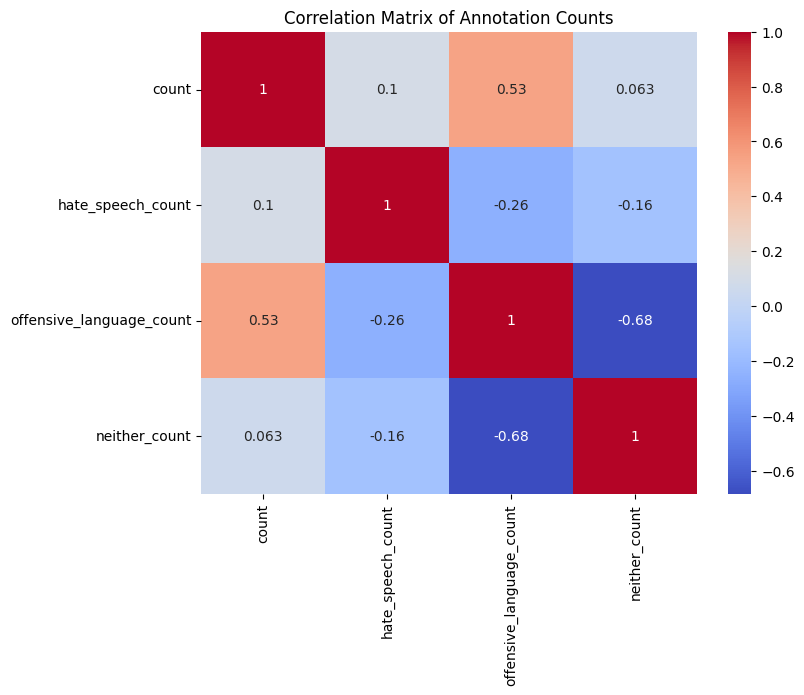

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a correlation matrix for the numerical columns
corr_matrix = data[['count', 'hate_speech_count', 'offensive_language_count', 'neither_count']].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix of Annotation Counts')
plt.show()